# **Intro**

The objective of this notebook is to sharpen my SQL skills as part of my Data Engineering toolbox. 
The project goal is to conduct queries on the Chinook data base to answer business questions. The chinook database contains data of customer purchases of music albums and tracks. 

The notebook is outlined as follows:
1. **Library import and essential functions**

2. **First Business question**

    2.1. Building the query
    
    2.2. Visualizing the results
    
    2.3. Providing recommendations to the business team
    
    
3. **Second Business question**

    3.1 Building the query
    
    3.2 Visualizing the results
    
    3.3 Analyzing the results
    
    3.4 Summarizing the findings and recommendations

## 1.Library import and essential functions

In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def run_query(q):
    ''' Runs a query and returns the result in a table format
    Arguments
    =========
    q: a string representing the query
    Returns
    =======
    Results of the query in table format'''
    #connect with database in a secure way that ensures connection is closed afterwards
    with sq.connect('chinook.db') as conn:
        #return the result of the query in table format
        return pd.read_sql(q,conn) 

In [3]:
def run_command(q):
    '''Run a SQL command that does not return a query result    
    Arguments
    =========
    q: a string representing the SQL command
    Returns
    =======
    Execute the command - no returns'''
    #connect with database
    with sq.connect('chinook.db') as conn:
        #instruct SQL to autcommit changes as per the SQL command
        conn.isolation_level = None
        #execute the command
        conn.execute(q)
        

In [4]:
def show_tables():
    '''Consult the database metadata to see which are tables and which are views    
    Arguments
    =========
    None
    Returns
    =======
    A table that shows the names and types of each tabel/view'''
    return run_query('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");')

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## **2.First Business question** 
We want to include three new artists in our US store's database. However, the record label has put forward four artists. We are interested in knowing which genres sel the best in the USA. So to inform our choice, can you tell us which are the top 3 genres that sell the most tracks in the US?  💵💲🤑💰

* Okay, I read 'sell the best' and 'sell the most'. 
* Now one could argue that this could mean the genres with the highest revenue. Another might say that is it the genres with the highest number of tracks sold. 
* These could lead to two different results as the price per unit might signficantly differ depending on the profile of the band. 🤔
* However, the later instructions asked for the genre with the number of tracks sold. So that removes ambiguity. 
Let us start 

Revisiting the chinook metadata I can see that i will need the country from the customer table, the genre name from the genre table and the total from the invoice table (each highlighted in red). The diagram below shows me the route i need to follow (highlighted in blue):
<img src="top 3 genres in US_v1.png" alt="Image Description">


### 2.1 Building the query

These are the steps I will need to implement: 🗺️🧳🛣️
* Step 1:Join the customer table and the invoice table and keep the country and the invoice_id.
    * Step 1.1: use a WITH filter to keep the country of choice. In this case, the USA. 
* Step 2: Join the resulting table from Step 1 with invoice_line. Keep the track_id, quantity from invoice_line and country from the step 1 table. 
* Step 3: Join the track table and the table resulting from Step2 using track_id key
    * Step 3.1: group by genre_id
    * Step 3.2: return the genre_id column from track table and the SUM of the quantity column from the invoice_line table
* Step 4: Join the table resulting rom Step 2 with the genre table
    * Step 4.1: return the name of the genre alongside the total quantity sold

In [6]:
# Step 1:Join the customer table and the invoice table and keep the country and the invoice_id.
#  * Step 1.1: use a WITH filter to keep the country of choice. In this case, the USA. 

query = '''WITH inv_per_country AS( 
                         SELECT invoice_id, cus.country
                         FROM invoice AS inv
                         LEFT JOIN customer AS cus ON cus.customer_id = inv.customer_id
                         WHERE cus.country = 'USA')
       SELECT * FROM inv_per_country
       '''

run_query(query)



,invoice_id,country
0,66,USA
1,75,USA
2,257,USA
3,268,USA
4,289,USA
...,...,...
126,365,USA
127,377,USA
128,455,USA
129,478,USA


Now that i have all the US invoices let us start with step 2 **(building on Step 1, so expect to see repeated SQL code)**

In [7]:
# DONE -> * Step 1:Join the customer table and the invoice table and keep the country and the invoice_id. DONE
# DONE ->    * Step 1.1: use a WITH filter to keep the country of choice. In this case, the USA. DONE
# EXECUTING THIS -> * Step 2: INNER Join the resulting table from Step 1 with invoice_line. Keep the track_id and quantity from invoice_line.



query = '''WITH inv_per_country AS( 
                         SELECT invoice_id, cus.country
                         FROM invoice AS inv
                         LEFT JOIN customer AS cus ON cus.customer_id = inv.customer_id
                         WHERE cus.country = 'USA'),
                         
                invLi_per_country AS (
                         SELECT track_id,
                                quantity
                                FROM invoice_line as invLi
                                INNER JOIN inv_per_country ON inv_per_country.invoice_id = invLi.invoice_id
                                GROUP BY invLi.invoice_id
                         )
                         
      SELECT * FROM invLi_per_country
       '''

run_query(query)

,track_id,quantity
0,1158,1
1,3448,1
2,1986,1
3,206,1
4,541,1
...,...,...
126,2507,1
127,2560,1
128,2188,1
129,1036,1


Now that i have all the track_ids for all US purchases, i can move to step 3 and seek the genre_id

In [8]:
# DONE -> * Step 1:Join the customer table and the invoice table and keep the country and the invoice_id. DONE
# DONE ->    * Step 1.1: use a WITH filter to keep the country of choice. In this case, the USA. DONE
# DONE -> * Step 2: INNER Join the resulting table from Step 1 with invoice_line. Keep the track_id and quantity from invoice_line.
# EXECUTING THIS -> * Step 3: Join the track table and the table resulting from Step2 using track_id key
#                     * Step 3.1: group by genre_id
#                     * Step 3.2: return the genre_id column from track table and the SUM of the quantity column from the invoice_line table


query = '''WITH inv_per_country AS( 
                         SELECT invoice_id, cus.country
                         FROM invoice AS inv
                         LEFT JOIN customer AS cus ON cus.customer_id = inv.customer_id
                         WHERE cus.country = 'USA'),
                         
                invLi_per_country AS (
                         SELECT track_id,
                                SUM(quantity) AS total
                                FROM invoice_line as invLi
                                INNER JOIN inv_per_country ON inv_per_country.invoice_id = invLi.invoice_id
                                GROUP BY invLi.track_id
                         ),
                         
               quantity_per_genreId AS (
                          SELECT 
                          tr.genre_id,
                          SUM(invLi_per_country.total) AS tracks_sold
                    FROM invLi_per_country
                    LEFT JOIN track AS tr ON tr.track_id = invLi_per_country.track_id
                    GROUP BY tr.genre_id 
                         )
                         
      SELECT * FROM quantity_per_genreID
       '''

run_query(query)

,genre_id,tracks_sold
0,1,561
1,2,14
2,3,124
3,4,130
4,6,36
5,7,22
6,8,6
7,9,22
8,10,2
9,12,13


Now all we need to do is to ge the genre name, 

In [9]:
# DONE -> * Step 1:Join the customer table and the invoice table and keep the country and the invoice_id. DONE
# DONE ->    * Step 1.1: use a WITH filter to keep the country of choice. In this case, the USA. DONE
# DONE -> * Step 2: INNER Join the resulting table from Step 1 with invoice_line. Keep the track_id and quantity from invoice_line.
# DONE -> * Step 3: Join the track table and the table resulting from Step2 using track_id key
#                     * Step 3.1: group by genre_id
#                     * Step 3.2: return the genre_id column from track table and the SUM of the quantity column from the invoice_line table
# EXECUTING -> * Step 4: Join the table resulting rom Step 2 with the genre table
#                * Step 4.1: return the name of the genre alongside the total quantity sold

US_top10_query = '''WITH inv_per_country AS( 
                         SELECT invoice_id, cus.country
                         FROM invoice AS inv
                         LEFT JOIN customer AS cus ON cus.customer_id = inv.customer_id
                         WHERE cus.country = 'USA'),
                         
                invLi_per_country AS (
                         SELECT track_id,
                                SUM(quantity) AS total
                                FROM invoice_line as invLi
                                INNER JOIN inv_per_country ON inv_per_country.invoice_id = invLi.invoice_id
                                GROUP BY invLi.track_id
                         ),
                         
               quantity_per_genreId AS (
                          SELECT 
                          tr.genre_id,
                          SUM(invLi_per_country.total) AS tracks_sold
                    FROM invLi_per_country
                    LEFT JOIN track AS tr ON tr.track_id = invLi_per_country.track_id
                    GROUP BY tr.genre_id 
                         ),
                         
                quantity_per_genre AS (
                          SELECT name AS genre,
                          quantity_per_genreId.tracks_sold AS tracks_sold
                          FROM genre
                          LEFT JOIN quantity_per_genreId ON quantity_per_genreId.genre_id = genre.genre_id
                          ORDER BY tracks_sold DESC
                          )
                          
      SELECT genre,
             tracks_sold,
             
             ROUND(100 * CAST(tracks_sold AS Float)/ (SELECT SUM(tracks_sold) FROM quantity_per_genre),2)
                         AS tracks_sold_perc
                    FROM quantity_per_genre
                    LIMIT 10;
       '''

run_query(US_top10_query)

,genre,tracks_sold,tracks_sold_perc
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


### 2.2 Visualizing the results
    


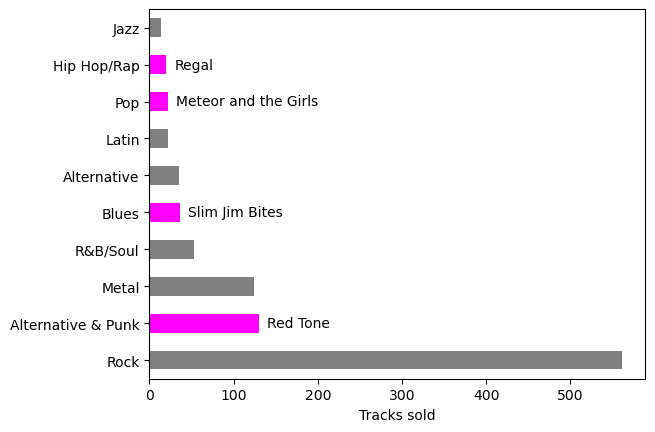

In [11]:
#save the result of the query
US_top10_genres = run_query(US_top10_query)
#lets use the genre as an index for our plot
US_top10_genres.set_index('genre', inplace = True, drop = True)

#let us create a dictionary of the candidate artists and their genres

candidate_artists = {'Hip Hop/Rap': 'Regal',
                    'Alternative & Punk': 'Red Tone',
                    'Pop': 'Meteor and the Girls',
                    'Blues': 'Slim Jim Bites'}

#let us use a threshold to highlight the 3 most selling genres
threshold  = 100
#plot the horizontal bar graph highlighting in red the top 3 genres
US_top10_genres['tracks_sold'].plot.barh(color=['magenta' if genre in candidate_artists else 'grey' for genre in US_top10_genres.index])
#remove ylabel as index is clear enough
plt.ylabel('')

#add xlabel
plt.xlabel('Tracks sold')


#let us annotate each genre with its corresponding candidate artist
for i, genre in enumerate(US_top10_genres.index):
    if genre in candidate_artists:
        plt.annotate(candidate_artists[genre],( US_top10_genres.loc[genre,'tracks_sold']+10,i-0.11))

### 2.3. Providing recommendations to the business team

Given the above results, i would recommend adding the following:
- Red Tone (Punk ranked 2nd) 🏆
- Slim Jim Bites (Blues ranked 5th) 🥈
- Meteor and the Girls (Pop ranked 8th). 🥉

Now, it is much more effective to present the results in a visually effective way. Our business team need to perceive our recommendations from the first glance of the chart (without a need for a lot of text). Let's do that with a bar graph.

The first business question has been successfully answered - Time to celebrate 👍✨ 🎉 🚀 🤘 

## **3. Second Business question**

Our business team has asked for the sales data for customers from each different country. 

In particular, I have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Let the analysis BEGIN 🔍🕵️‍♂️🕵️‍♂️🤔❓

### 3.1 Building the query


Looking at the results requested, they can all be extracted from a table that contains the customer and invoice data. So let us create a VIEW that combines these two tables. We can then use the VIEW to call it multiple times and extract the required information. 

In [12]:
command_view_cus_inv = '''
                                CREATE VIEW cus_inv AS 
                                SELECT *
                                FROM customer AS cus
                                LEFT JOIN invoice AS inv ON inv.customer_id = cus.customer_id
                                
'''
view_cus_inv = 'cus_inv'
run_command('DROP VIEW ' + view_cus_inv )
run_command(command_view_cus_inv)

Now let us divide our query into two subqueries:
* First subquery groups all our data by country and selects the information we are after
    * number of customers per country
    * total sales per country
    * average order value per country
    * average sales per customer per country
*  Given that there are several countries with a single customer let us group them into a 'Other' category. We need then to explicitly mention this assumption when presenting the data to the business team 

* Finally, using the above WITHs we can write the final query that gets us all the data we need in a single pandas dataframe


In [182]:
query = '''WITH cus_per_country AS (SELECT country, 
                                    COUNT(DISTINCT(customer_id)) AS number_of_customers,
                                    SUM(total) AS total,
                                    AVG(total) AS average_per_order,
                                    CAST(SUM(total) AS FLOAT)/COUNT(DISTINCT(customer_id)) AS average_per_customer
                                    FROM cus_inv 
                                    GROUP BY country),
            
                cus_per_country_other AS (SELECT *, 
                                                CASE 
                                                    WHEN number_of_customers == 1 THEN 'Other'
                                                    ELSE country
                                                END AS country_2
                                            FROM cus_per_country
                                            )
                                            
                SELECT country_2 AS country, 
                        SUM(number_of_customers) AS number_of_customers,
                        SUM(total) AS total,
                        average_per_order,
                        average_per_customer,
                        CASE 
                            WHEN LOWER(country_2) = 'other' then 0
                            ELSE 1
                            END AS other_2_bottom
                FROM cus_per_country_other
                GROUP BY country_2
                ORDER BY other_2_bottom DESC, total DESC;
                
            '''

data_per_country = run_query(query)

In [183]:
data_per_country

,country,number_of_customers,total,average_per_order,average_per_customer,other_2_bottom
0,USA,13,1040.49,7.942672,80.037692,1
1,Canada,8,535.59,7.047237,66.948750,1
2,Brazil,5,427.68,7.011148,85.536000,1
3,France,5,389.07,7.781400,77.814000,1
4,Germany,4,334.62,8.161463,83.655000,1
5,Czech Republic,2,273.24,9.108000,136.620000,1
6,United Kingdom,3,245.52,8.768571,81.840000,1
7,Portugal,2,185.13,6.383793,92.565000,1
8,India,2,183.15,8.721429,91.575000,1
9,Other,15,1094.94,7.920000,39.600000,0


Now let's create a dashboard to impress our business team  ✨✨✨😎😎😎🤩🤩🤩

### 3.2 Visualizing the results
    


C:\Users\basha\AppData\Local\Temp\ipykernel_17040\4165461345.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), color='blue')
C:\Users\basha\AppData\Local\Temp\ipykernel_17040\4165461345.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), color='red')


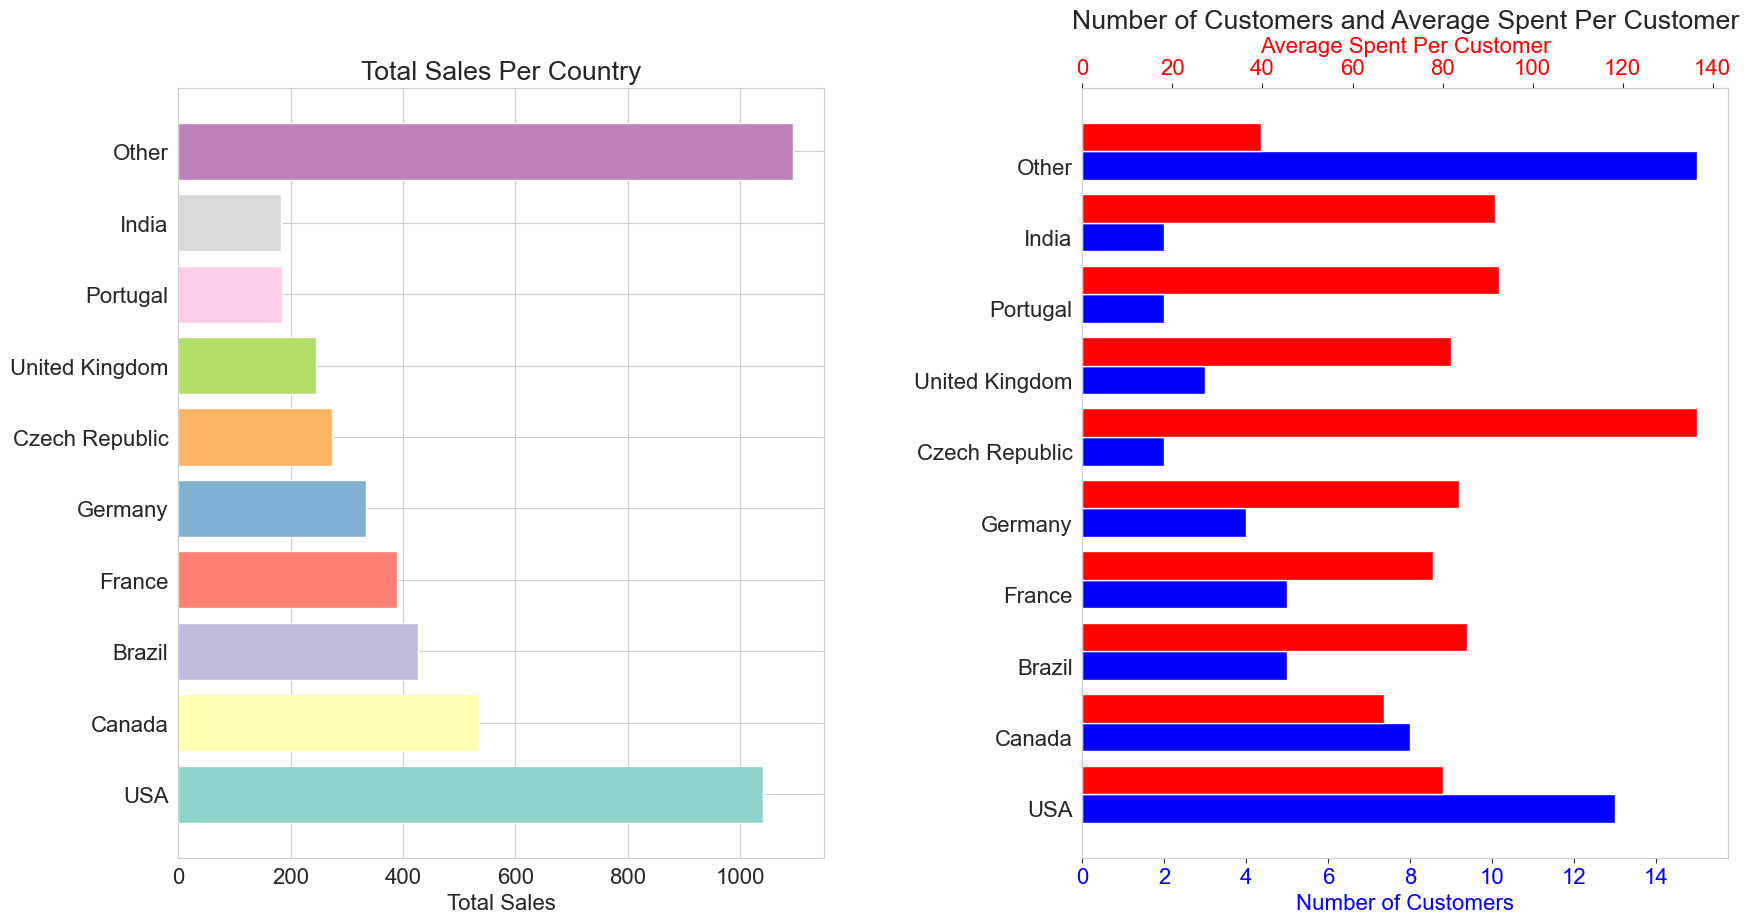

In [202]:
import numpy as np
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})
figure, ax = plt.subplots(1,2, figsize = (20,10))
plt.subplots_adjust(wspace=0.4, hspace =0.4)
ax = ax.flatten()
cmap = plt.get_cmap('Set3') 
values = np.arange(data_per_country.shape[0])

ax[0].barh(data_per_country['country'], data_per_country['total'], color = cmap(values))
ax[0].set_xlabel('Total Sales')
ax[0].set_title('Total Sales Per Country')

countries = data_per_country['country']
values1 = data_per_country['number_of_customers']
values2 = data_per_country['average_per_customer']
countries_index = np.arange(data_per_country.shape[0])
# Create the first bar chart using the first y-axis
ax[1].barh(countries_index, values1, 0.4,color='blue')
ax[1].set_xlabel('Number of Customers', color = 'blue')
ax[1].tick_params(axis='y', color = 'blue')
ax[1].set_xticklabels(ax[1].get_xticklabels(), color='blue')
ax[1].set_yticks(countries_index,countries)
ax[1].grid(False)
# Create the second axes sharing the x-axis with the first axes
ax2 = ax[1].twiny()

# Create the second bar chart using the second y-axis
ax2.barh(countries_index+0.4, values2, 0.4,color='red')
ax2.set_xlabel('Average Spent Per Customer', color='red')
ax2.set_xticklabels(ax2.get_xticklabels(), color='red')
ax2.grid(False)
# ax2.tick_params(axis='y', labelcolor='red')
# ax2.spines["top"].set_visible(False)
# ax2.spines["right"].set_visible(False)
# ax2.tick_params(top="off", right="off", left="off", bottom="off")

# Set the title
ax[1].set_title('Number of Customers and Average Spent Per Customer')

# Display the plot
plt.show()

### 3.3 Analyzing the results
    


**North America Market** 


Looking at the first graph, clearly, our biggest market is the US. Most of our resources should be employed in this market to maintain and grow. 
With Canada second in line, and due to similarity in economy, culture and demographics as the US, it is worth exploring why it is only providing half of the US sales. It seems there is great potential there to increase revenue. 

Let us shift to the second graph that shows both the Number of customers and the average spent for each country. Canada has the lowest average spent across all other countries. The number of customers is also low relative to the US. We need to understand why arent we reaching out to the Canadian customers and why is there average spent so low. Are we missing products that appeal to the Canadian citizens? 

**Rest of the World** 

The rest of the world shows a similar pattern, a high average spent per customer but a low number of customers (all relative to the North America market). The first thing to do, is to identify the countries where there is a large number of customers with similar profiles to the existing ones. We need to know that the current customers are not anomalies. It may be that we have a few die hard fans and economically capable customers in certain countries. For example, we have two customers from the Czech Republic with an average spent of $136.6. Is that an anomlay, or are there more customers with similar profile? If there is, then Czech Republic would be a priority for market growth. 

### 3.4 Summarizing the findings and recommendations

* **US**: maintain **growth with a focus on increasing average spent per customer
* **Canada**: Focus** on in**creasing the average spent per customer as well as the number of customers
* **Rest of the world**: 
    * Conduct market and customer research to identify countries with largest number of customers with similar economic and cultural background as the existing ones. 
    * Invest in increasing the number of customers